[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/Neuro-AI-Lab/SNN-Tutorial-with-snnTorch)

# Tutorial 1 - Spike Encoding
## By Jason K. Eshraghian (www.ncg.ucsc.edu)
### Translated By Park SungSoo (https://github.com/Moerai)


<a href="https://colab.research.google.com/drive/1wMPFkHkVdfVyYFmtsF9qP4e-zx3p65hK?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/Neuro-AI-Lab/SNN-Tutorial-with-snnTorch) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/Neuro-AI-Lab/SNN-Tutorial-with-snnTorch)


snnTorch 튜토리얼 시리즈는 다음 논문을 토대로 만들어졌습니다. 만약 코드 혹은 리소스를 업무에 사용하고자 한다면, 다음 출처를 이용하는 것을 고려하여 주세요.

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>

튜토리얼 목표

snnTorch를 이용하여
* 데이터셋을 Spiking 데이터 셋으로 어떻게 변환 하는지,
* spiking 데이터 셋을 어떻게 시각화하는지, 
* 어떻게 랜덤 Spike Trains를 생성하는지

학습한다.

# 소개
빛은 망막이 광자를 Spike로 바꿀 때 우리가 보는 것입니다. 냄새는 휘발된 분자가 Spike로 바뀔 때 우리가 느끼는 것입니다. 이처럼 뇌에서는 "Spike"로 정보를 처리합니다.

우리의 최종 목표가 Spike Neural Network(SNN)을 구축하는 것이라면, Input에서도 Spike를 사용하는 것이 타당합니다. 일반적으로 Spike가 아닌 input을 사용하지만, 인코딩 데이터의 매력은 Spike, Sparsity, Static-Suppression(a.k.a event-driven processing) 3가지에서 비롯됩니다.



1.   **Spikes**: (a-b) 생물학적 뉴런은 약 100mV의 진폭의 전기적 자극인 Spike를 통해 처리하고 통신합니다. (c) 뉴런의 많은 계산 모델은 이 전압 burst를 '1' 또는 '0'이라는 개별 단일 비트 이벤트로 단순화 합니다. 이것은 high precision value에서 표현 하는 것보다 하드웨어에서 표현 하는 것이 훨씬 간단합니다. (뉴로모픽 하드웨어)

2.   **Sparsity**: (c) 뉴런은 대부분의 시간을 휴식 상태에서 보냅니다. 따라서 주어진 시간에 대부분의 활성화 정도를 0으로 합니다. Sparse 벡터/텐서는 0이 많이 모여 있기 때문에 저장하기에 용이합니다. 또한 Sparse 벡터/텐서는 Sparse activation을 시냅스 가중치로 곱해야 합니다. 대부분의 값에 '0'을 곱하면 메모리에서 많은 네트워크의 매개 변수를 읽을 필요가 없습니다. 이것은 뉴로모픽 하드웨어가 매우 효율적일 수 있음을 의미합니다.

3.   **Static-Suppression (a.k.a, event-driven processing**: (d-e) 감각 주변부(sensory periphery)는 처리해야 할 새로운 정보가 있을 때만 정보를 처리합니다. (e)의 각 픽셀은 조도의 *변화*에 반응하므로 대부분의 이미지가 차단됩니다. 기존의 신호처리에서는 모든 채널/픽셀이 글로벌 샘플링/셔터 rate를 준수해야 하므로 어떠한 발생이 얼마나 빈번한지 감지하는 속도가 느려집니다. 요즘 Event-driven processing은 변하지 않는 input을 차단함으로써 희소성(Sparsity)와 전력 효율성에만 기여했지만, 종종 훨씬 더 빠른 처리 속도를 보여주기도 한다.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/3s.png?raw=true' width="600">
</center>

이 튜토리얼에서는 일부 Non-spiking input 데이터(즉, MNIST 데이터 세트)가 있고 몇 가지 기술들을 이용하여 Spike encoding을 하려고 합니다.

그럼 시작~

snnTorch의 최신 PyPi 배포판을 설치합니다.

In [ ]:
!pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.5/95.5 KB 4.6 MB/s eta 0:00:00


## 1. Setting up the MNIST Dataset

### 1.1. Package Import 및 환경 설정

In [ ]:
import snntorch as snn
import torch

In [ ]:
# Training Parameters
batch_size=128
data_path='/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float

### 1.2 다운로드 데이터셋

In [ ]:
from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



위의 코드 블록이 MNIST 서버 다운과 같은 이유로 오류를 발생시키는 경우에는 아래 코드 블록에서'#'을 제거한 후 사용합니다.

In [ ]:
# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)

진짜 네트워크 훈련을 시작하기 전까지는 대규모 데이터 세트가 필요하지 않습니다.
`snntorch.utils` 에는 데이터 세트를 수정하는 데 유용한 기능이 몇 가지 포함되어 있습니다. `data_subset`을 적용하여 `subset`에 정의된 인수만큼 데이터 집합을 줄입니다.

*예를 들어, `subset=10`의 경우, 60,000개의 훈련 세트가 6,000개로 줄어들 것입니다.*

In [ ]:
from snntorch import utils

subset = 10
mnist_train = utils.data_subset(mnist_train, subset)
print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 6000


### 1.3 DataLoader 만들기

위에서 생성된 Dataset 개체는 데이터를 메모리에 로드하고 DataLoader는 데이터를 일괄처리합니다. PyTorch의 DataLoader는 데이터를 네트워크로 전달하기 위한 편리한 Interface입니다. DataLoader는 mini-batche로 나누어진 Iterator를 Return합니다.(``batch_size``)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

## 2. 스파이크 인코딩

Spiking Neural Networks (SNNs)은 시간에 따라 변화하는 데이터를 활용하기 위해 만들어졌습니다. 그럼에도 불구하고, MNIST는 시간에 따라 달라지는 데이터 세트가 아닙니다. 그래서 SNN에서 MNIST를 사용하는 데는 두 가지 옵션이 있습니다.

1. 각 time step에서 동일한 training sample $\mathbf{X}\in\mathbb{R}^{m\times n}$ 을 네트워크에 반복적으로 전달합니다. 이는 MNIST를 정적이고 변하지 않는 비디오로 변환하는 것과 같습니다. $\mathbf{X}$ 의 각 원소들은 0과 1: $X_{ij}\in [0, 1]$ 사이에서 정규화된 고도로 정밀한 값을 가질 수 있습니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_1_static.png?raw=true' width="700">
</center>

2. 입력을 시퀀스 길이가 `num_steps`인 스파이크 열로 변환합니다. 여기서 각 feature/pixel은 개별 값 $X_{i,j} \in \{0, 1\}$ 를 가지고 있습니다. 이 경우 MNIST는 원본 이미지와의 관계를 특징으로하는 시간변동(time-varying) 스파이크 시퀀스로 변환됩니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_2_spikeinput.png?raw=true' width="700">
</center>

첫 번째 방법은 매우 간단하며, SNN의 시간 역학(temporal dynamic)을 완전히 활용하지 않습니다. 그래서 두 번째 방법(data-to-spike conversion encoding)을 조금 더 자세히 고려해 보겠습니다.

`snntorch.spikegen`(스파이크 생성)모듈은 데이터를 스파이크로 변환하는 전 과정을 단순화하는 일련의 기능을 포함합니다. 현재 `snntorch`에서 스파이크 인코딩에 사용할 수 있는 세 가지 옵션이 있습니다.

1. Rate coding: [`spikegen.rate`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.rate)
2. Latency coding: [`spikegen.latency`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.latency)
3. Delta modulation: [`spikegen.delta`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.delta)

차이점은 다음과 같습니다.

1.   *Rate coding*은 input features를 사용하여 스파이크 **주파수(frequency)**를 결정합니다.
2.   *Latency coding*은 input features를 사용하여 스파이크 **타이밍**을 결정합니다.
3.   *Delta modulation* input feature의 시간의 **변화**를 이용하여 스파이크를 생성합니다.

### 2.1 Rate coding of MNIST

input data를 rate code로 변환하는 한 가지 예는 다음과 같습니다. 각 정규화된 input feature $X_{ij}$ 는 특정 시간 단계에서 이벤트(Spike)가 발생하여 Rate code화 된 값 $R_{ij}$ 를 반환(return)하는 확률로 사용됩니다. 이것은 베르누이 시행으로 처리될 수 있습니다 : $R_{ij}\sim B(n,p)$

여기서 시행 횟수는 $n = 1$이고, 성공 확률(예측)은 $p=X_{ij}$입니다. 명시적으로, 스파이크가 발생할 확률은 다음과 같습니다.

$${\rm P}(R_{ij}=1) = X_{ij} = 1 - {\rm P}(R_{ij} = 0)$$

값 '0.5'로 채워진 백터를 만들고 위의 기법을 사용하여 인코딩을 해봅니다.

In [ ]:
# Temporal Dynamics
num_steps = 10

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"Converted vector: {rate_coded_vector}")

print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Converted vector: tensor([1., 0., 1., 0., 1., 0., 1., 0., 0., 1.])
The output is spiking 50.00% of the time.


`raw_vector`의 길이를 늘려서 다시 시도해봅니다.

In [ ]:
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

The output is spiking 50.00% of the time.


`num_steps` $\rightarrow\infty$에 따라 스파이크의 비율이 원시 값(original raw value)에 근접합니다.

MNIST이미지의 경우, 이 스파이킹이 일어날 확률은 픽셀 값과 연관이 있습니다. 흰색 픽셀은 스파이크 가능성 100%에 해당하며 검은색 픽셀은 스파이크를 생성하지 않습니다. 자세한 내용은 아래의 'Rate Coding" 컬럼을 참고하면 됩니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_3_spikeconv.png?raw=true' width="1000">
</center>

유사한 방식으로 `spikegen.rate`를 사용하여 Rate-Code화 된 데이터 샘플을 생성 할 수 있습니다. MNIST의 각 샘플은 하나의 이미지에 불과하기 때문에 `num_steps`를 사용하여 시간을 늘려서 반복할 수 있습니다.

In [ ]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)
#$
# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)

input이 $[0,1]$을 벗어나면 이 값은 더 이상 확률을 나타내지 않습니다. 이러한 경우는 feature가 확률을 대신 보장하도록 자동으로 클립되어(clipped)집니다.

input data의 구조 ``[num_steps x batch_size x input dimensions]`` :

In [ ]:
print(spike_data.size())

torch.Size([100, 128, 1, 28, 28])


### 2.2 시각화

#### 2.2.1 Animation
snnTorch는 스파이킹 뉴런을 시각화, 플로팅 및 애니메이션화하는 [`snntorch.spikeplot`](https://snntorch.readthedocs.io/en/latest/snntorch.spikeplot.html)모듈을 포함하고 있습니다.

In [ ]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

데이터의 한 표본을 plot하기 위해, `spike_data`, ``[T x B x 1 x 28 x 28]`` 의 배치(B) 차원에서 단일 표본으로 index 합니다:

In [ ]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


`spikeplot.animator`는 2-D 데이터를 애니메이션화하는 것을 매우 단순하게 만듭니다.<br>
참고 : 노트북을 로컬에서 실행하는 경우 ffmpeg를 설치해야될 수 있습니다.
Python 환경의 경우 `pip install ffmpeg` 
Conda 환경의 경우 `conda install -c conda-forge ffmpeg`.<br>
만약 ffmpeg를 찾을 수 없으면, 아래 줄의 주석에서 ffmpeg.exe의 경로를 수정하면 됩니다.

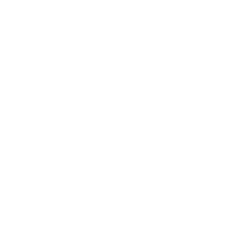

In [ ]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

HTML(anim.to_html5_video())

In [ ]:
# If you're feeling sentimental, you can save the animation: .gif, .mp4 etc.
anim.save("spike_mnist_test.mp4")

연관된 target label은 다음과 같이 인덱싱 할 수 있습니다:

In [ ]:
print(f"The corresponding target is: {targets_it[0]}")

The corresponding target is: 5


MNIST는 그레이스케일 이미지를 feature로 하며, 화이트 텍스트는 모든 time step에서 100% 스파이킹을 보장합니다.<br>
빈도를 낮춰서 다시 한 번 해볼까요? 빈도는 `gain`을 설정함으로써 조절 할 수 있습니다. 아래 블록에서는 스파이킹 빈도를 25%로 줄일 것입니다.

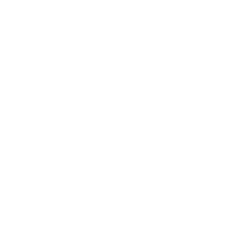

In [ ]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

In [ ]:
# Uncomment for optional save
# anim.save("spike_mnist_test2.mp4")

이제 시간이 지남에 따라 스파이크를 평균화하고 input image를 재구성합니다.

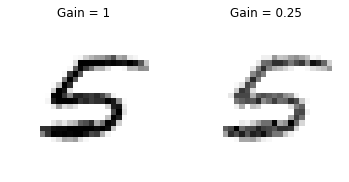

In [ ]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

아 경우에는 `gain=0.25`이 `gain=1`보다 흐릿(lighter)합니다. 왜냐하면 스파이킹 확률이 4배 감소했기 때문입니다.

#### 2.2.2 Raster Plots

다른 방법으로는 input 샘플의 Raster Plot을 생성할 수 있습니다. 이를 위해서 샘플을 '시간(time)'이 첫번째 차원(dimension)인 2-D 텐서(tensor)로 재구성(`reshape`)합니다. 그 후 이 샘플을 `spikeplot.raster` 함수에 전달합니다.

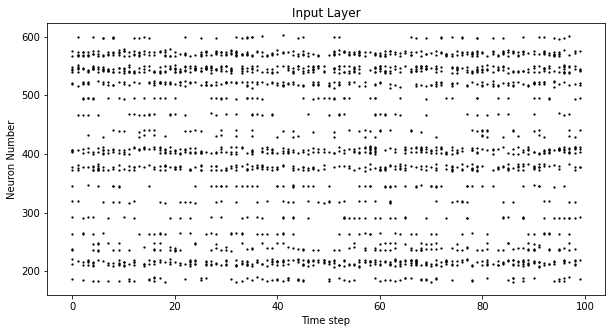

In [ ]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

다음 코드는 단일 뉴런으로 인덱싱하는 방법을 보여줍니다. input 데이터에 따라 스파이크가 있는 뉴런을 찾기까지 0에서 784사이에 다른 뉴런을 시도해야 할 수도 있습니다.

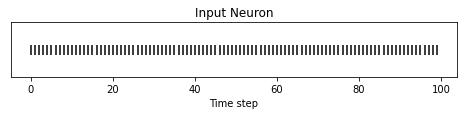

In [ ]:
idx = 210  # index into 210th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

#### 2.2.3 Rate Coding 요약
Rate Coding의 아이디어는 사실 꽤 많은 논란을 가지고 있습니다. 우리의 감각 주변부에서 Rate Coding이 일어난다고 생각하고 있지만, 피질이 정보를 스파이크 Rate로 전역적으로(globally) 인코딩한다고 확신하지는 않습니다. 아래에는 그 이유가 있습니다.

*   **Power Consumption:** 효율을 위해 최적화된 자연. 모든 종류의 작업을 수행하려면 여러 스파이크가 필요하며 각 스파이크는 전력을 소비합니다. 실은, [Olshausen and Field's work in "What is the other 85% of V1 doing?"](http://www.rctn.org/bruno/papers/V1-chapter.pdf)는 Rate Coding이 1차 시각 피질(V1)에서 15%만의 뉴런 활동을 설명할 수 있음을 보여줍니다. Rate Coding은 자원이 제한되고 매우 효율적인 뇌의 유일한 메커니즘이 아닐 것입니다.

*   **Reaction Response Times:** 인간의 반응 시간은 대략 250ms 정도 됩니다. 만약 인간의 뇌에서 뉴런의 평균 firing rate가 10Hz 정도라면, 인간은 반응 시간 범위 내에서 약 2개의 스파이크만 처리 할 수 있습니다.

그렇다면 전력 효율이나 대기 시간에 최적이 아닌 Rate Code를 사용하는 이유는 무엇일까요?
연구자들은 비록 인간의 뇌가 데이터를 Rate로 처리하지 않더라도, 인간의 생물학적 센서가 Rate로 처리한다고 꽤 확신합니다. Power/Latency의 단점은 큰 노이즈의 단단함을 보여줌으로써 부분적으로 상쇄된다는 것입니다. 스파이크가 발생한 곳에 더 많은 것이 있기 때문에 일부 스파이크가 발생하지 않더라도 괜찮습니다.

게다가 이런 연구도 있습니다([Hebbian mantra of "neurons that fire together, wire together"](https://doi.org/10.2307/1418888)). 만약 많은 스파이크가 일어난다면, 이것은 많은 배움이 있다는 것을 암시할 수 있다. SNN을 훈련하는 것이 어려운 것으로 판명된 일부의 경우에, Rate Code를 통해 더 많은 firing을 장려하는 것이 가능한 해결책 중 하나로 제시되어집니다.

Rate coding은 뇌의 다른 인코딩 체계와 함께 거의 활실히 작동하고 있습니다. 다음 섹션에서는 다른 인코딩 메커니즘을 고려할 것입니다.

그 것은 `spikegen.rate` 함수룰 커버(cover)합니다.

더 많은 정보를 찾고자 한다면 : [here](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html).



### 2.3 Latency Coding of MNIST
Temporal codes는 뉴런의 정확한 발사 시간에 대한 정보를 포착합니다; 단일 스파이크는 발사 빈도에 의존하는 Rate code보다 훨씬 더 많은 의미를 내포하고 있습니다. 이는 Noise에 더 민감하게 작용하지만, SNN 알고리즘을 실행하는 하드웨어가 소비하는 전력을 몇 배로 줄일 수 있습니다.

`spikegen.latency`는 각 input이 full time sweep 동안 최대 **1회**까지 실행되도록 하는 함수입니다.

`1`에 가까운 피쳐는 먼저 fire되고 `0`에 가까운 피쳐는 나중에 fire됩니다. 즉, MNIST의 경우 밝은 픽셀은 더 일찍 fire하고 어두운 픽셀은 더 늦게 fire합니다.

다음 블록은 이것이 어떻게 작동하는지를 보여줍니다. 만약 회로이론을 까먹었거나, 수학을 잘 모르더라도 걱정하지 않아도 됩니다. 중요한 것은 **big** input은 **빠른** 스파이크를 의미하고 **small** input은 **늦은** 스파이크를 의미한다는 것만 이해하면 됩니다.

---

**선택 : Latency Code 메카니즘의 파생 모델**

기본적으로 스파이크 타이밍은 input feature를 RC회로의 전류 주입 $I_{in}$ 으로 처리하여 계산됩니다. 이 전류는 전하를 커패시터로 이동시켜 $V(t)$를 증가시킵니다. 연구자들은 일단 도달하면 Spike를 생성하는 트리거 전압 $V_{thr}$가 있다고 가정합니다. 그러면 다음과 같은 질문이 됩니다. *주어진 input current (그리고 동등한 input feature)에서 스파이크가 생성되는 데 얼마나 시간이 걸릴까?*

카르히호프의 전류 법칙(KCL)인 $I_{in} = I_R + I_C$룰 시작으로 나머지 파생은 시간과 Input 사이의 로그 관계로 이어집니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_4_latencyrc.png?raw=true' width="600">
</center>

---

다음 함수는 위의 결과를 사용하여 intensity $X_{ij}\in [0,1]$의 feature를 latency code 응답 $L_{ij}$로 변환하여 줍니다.

In [ ]:
def convert_to_time(data, tau=5, threshold=0.01):
  spike_time = tau * torch.log(data / (data - threshold))
  return spike_time 

이제 위의 함수를 사용하여, input feature intensity와 해당 스파이크 시간 사이의 관계를 시각화합니다.


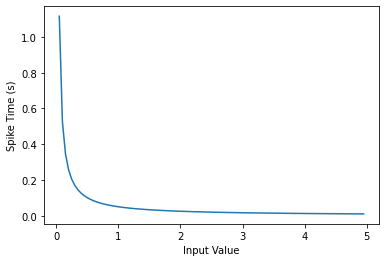

In [ ]:
raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()

Value가 작을수록 지수 의존성으로 스파이크가 늦게 발생합니다.

`spike_times` 백터는 스파이크 자체(1과 0)를 포함하는 희소(sparse) 텐서가 아니라 스파이크가 트리거되는 시간을 포함합니다.
SNN 시뮬레이션을 실행할 때 스파이크를 사용하는 이점을 모두 얻으려면 1/0 표현이 필요합니다.
이 전체 프로세스는 `spikegen.latency`를 사용하여 자동화될 수 있으며, 여기 `data_it`의 MNIST 데이터 세트에서 minibatch를 전달합니다.

In [ ]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)

몇몇 주장에는 다음이 포함되어 있습니다:

* `tau`: 회로의 RC 시간 상수. 기본적으로 입력 기능은 RC 회로에 주입되는 정전류로 처리됩니다. ``tau``가 높으면 firing 속도가 느려집니다.

* `threshold`: 막 전위(membrane potential)[세포막에서 발생하는 전위차] firing threshold. input 전류가 membrane을 임계 값(threshold)까지 구동하기에 충분하지 않기 때문에 이 임계값 미만의 입력 값에는 폐쇄형(closed-form) 솔루션이 없습니다. 임계 값 미만의 모든 값이 clip되고 final time step에 할당 됩니다.

#### 2.3.1 Raster plot

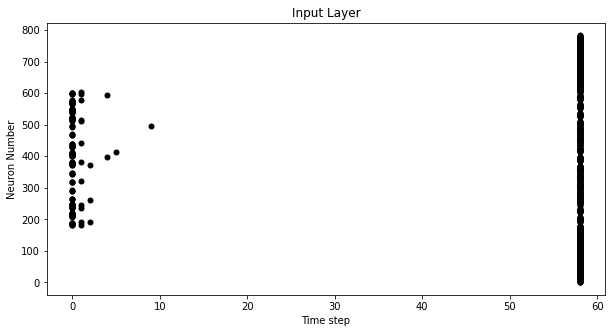

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

# optional save
# fig.savefig('destination_path.png', format='png', dpi=300)

raster plot을 이해하려면, 높은 강도(intensity)는 먼저 fire하는 특징을 가지고 있는 반면에 낮은 강도는 마지막에 fire하는 것을 특징으로 한다는 것을 알아야 합니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_5_latencyraster.png?raw=true' width="800">
</center>

로그 코드는 다양한 입력 값의 부족(즉, 중간 톤/회색 스케일 기능의 부분)과 결합되어 플롯의 두 영역에서 상당한 클러스터링을 유발합니다.
밝은 픽셀은 실행 시작 시 발사를 유도하고, 어두운 픽셀은 끝에서 발사를 유도합니다. 연구자들은 스파이크 시간을 늦추기 위해 `tau`를 증가시키거나 선택적 인수 `linear=True`를 설정하여 스파이크 시간을 선형화 할 수 있습니다.

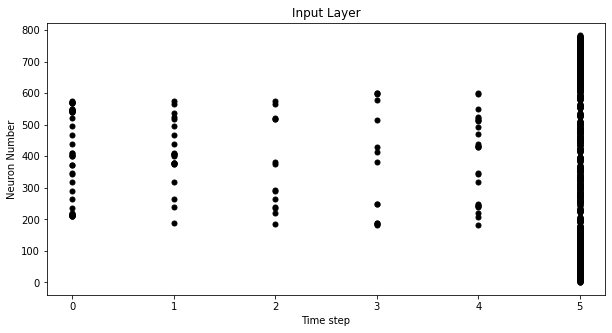

In [ ]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

firing time의 확산은 지금 훨씬 더 고르게 분포되어 있습니다. 이는 아래에 표시된 규칙에 따라 로그 방정식을 선형화함으로써 달성됩니다. RC 모델과 달리 모델에 대한 물리적 근거는 없습니다. 그냥 더 간단합니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_6_latencylinear.png?raw=true' width="600">
</center>

그러나 시뮬레이션 범위가 100 시간 단계(time step)이므로 모든 fire가 처음부터 5시간 단계 내에 어떻게 발생하는지를 주목해야합니다. 이것은 아무것도 하지 않는 쓸모없는 시간 단계가 많다는 것을 나타냅니다. 이 문제는 시간 상수를 느리게 하기 위해 `tau`를 늘리거나 선택적 인수 `normalize=True`를 `num_steps`의 전체 범위에 걸쳐 설정하여 해결할 수 있습니다.

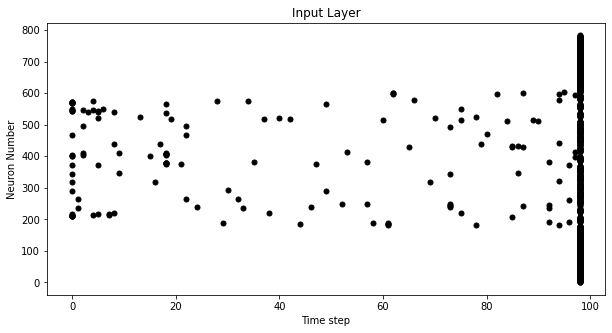

In [ ]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

Rate coding에 비해 latency coding의 주요 이점 중 하나는 sparsity입니다. 만약 뉴런이 관심 있는 시간 동안 최대 한 번 fire하도록 제한된다면, 이것은 저전력 작동을 촉진합니다.

위에 표시된 시나리오에서 대부분의 스파이크는 input feature가 임계값 아래로 떨어지는 최종 시간 단계에서 발생합니다. 어떤 의미에서, MNIST 샘플의 어두운 배경은 유용한 정보를 제공하지 않습니다.

`clip=True`를 설정함으로써 이러한 불필요한 피쳐를 제거할 수 있다.

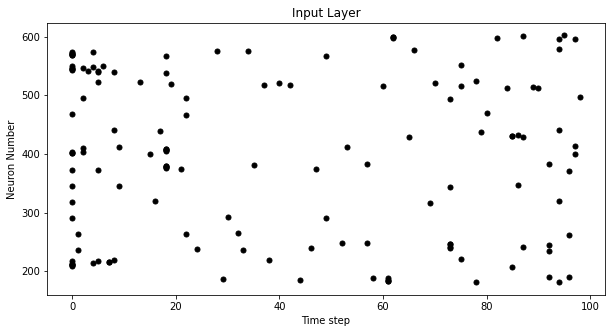

In [ ]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, 
                              clip=True, normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

보기에 훨신 좋습니다!!

#### 2.3.2 Animation
애니메이션을 만들기 위해 이전과 동일한 코드 블록을 실행합니다.

In [ ]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


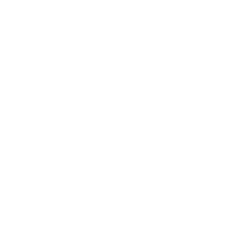

In [ ]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())

이 애니메이션은 분명히 비디오 형태로 이해하기가 훨씬 어렵지만, 날카로운 눈으로 대부분의 스파이크가 발생하는 초기 프레임을 엿볼 수 있습니다. 해당 target 값으로 인덱싱하여 값을 확인합니다.

In [ ]:
# Save output: .gif, .mp4 etc.
# anim.save("mnist_latency.gif")

In [ ]:
print(targets_it[0])

tensor(5)


`spikegen.latency`함수의 기능입니다. 더 많은 정보는 [이 링크](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html)에서 얻을 수 있습니다.

### 2.4 Delta Modulation
망막은 적응한다는 이론이 있다. 망막은 처리할 새로운 무언가가 있을 때만 정보를 처리할 것이다. 시야에 변화가 없으면 광수용체 세포가 fire하기 쉽습니다.

다시 말해서 **생물학은 사건 중심적**입니다. 신경세포는 변화를 통해 성장합니다.

좋은 예로, 몇몇 연구자들은 망막에서 영감을 받은 이미지 센서, 예를들면 [Dynamic Vision Sensor]((https://ieeexplore.ieee.org/abstract/document/7128412/))를 설계하는데 일생을 바쳤습니다. 첨부된 링크는 10여년 전의 것이지만, [이 영상 속](https://www.youtube.com/watch?v=6eOM15U_t1M&ab_channel=TobiDelbruck)의 작업은 시대를 앞서가고 있었습니다.

Delta modulation은 event-driven spiking을 기반으로 합니다. `snntorch.delta` 함수는 시계열 텐서를 입력으로 받아들입니다. 모든 시간 단계(time step)에서 각 후속 피쳐 간의 차이를 사용합니다. 기본적으로 차이가 *양(positive)* 그리고 *임계값 $V_{thr}$ 보다 클 경우* 스파이크가 생성됩니다:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_7_delta.png?raw=true' width="600">
</center>

먼저 설명을 위해 우리만의 입력 텐서를 만드는 인위적인 예시를 생각해봅니다.

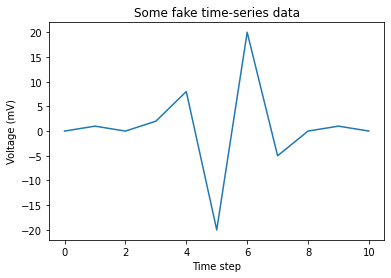

In [ ]:
# Create a tensor with some fake time-series data
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# Plot the tensor
plt.plot(data)

plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

임의로 선택한 `threshold=4`를 사용하여 위의 텐서를 `spikegen.delta` 함수에 전달합니다.

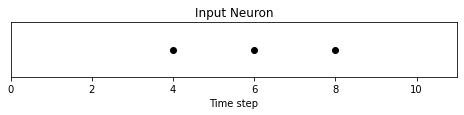

In [ ]:
# Convert data
spike_data = spikegen.delta(data, threshold=4)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

$data[T]$와 $data[T+1]$의 차이가 $V_{thr}=4$보다 크거나 같은 세 가지 시간 단계(Time Step)이 있습니다. 이것은 세 개의 스파이크가 있다는 것을 의미합니다.

위에서 $-20$까지의 큰 하락은 포착되지 않았습니다. 데이터에 부정적인 변동이 중요한 경우에는 선택적 인수(optional argument)인 `off_spike=True`를 사용 할 수 있습니다.

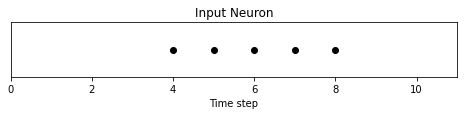

In [ ]:
# Convert data
spike_data = spikegen.delta(data, threshold=4, off_spike=True)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

위에서는 추가 스파이크를 생성했지만, 실제로는 전체 그림이 아닙니다.

텐서를 출력하면 `-1`의 값을 갖는 "오프 스파이크(off-spikes)"의 존재를 보여줍니다.

In [ ]:
print(spike_data)

tensor([ 0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  1.,  0.,  0.])


`spikegen.delta`는 가짜 데이터 샘플에서만 입증되었지만, 진정한 용도는 충분히 큰 변경/이벤트에 대한 스파이크만 생성하여 시계열 데이터를 압축하는 것입니다.

이것으로 세 가지 주요 스파이크 변환 함수를 배워보았습니다! 이 예제에서 자세히 설명하지 않은 세 가지 변환 기법 각각에 대한 추가 기능 또한 여전히 존재합니다. 특히, 우리는 입력 데이터를 인코딩하는 것만 검토했습니다. 우리는 대상을 인코딩하는 방법과 필요할 때를 고려하지 않았습니다. 자세한 내용은 [이 문서](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html)를 참조하는 것이 좋습니다.

## 3. Spike Generation (Optional)
만약에 우리가 실제로 어떠한 데이터도 가지고 있지 않다면 어떨까요? 무작위로 생성된 스파이크 트레인을 처음부터 원한다고 생각해봅니다. `spikegen.rate` 내부에는 실제로 스파이크 변환 단계를 수행하는 `rate_conv`라는 중첩 함수가 있습니다.

예제는 무작위로 생성된 `torchTensor`를 초기화 하는 것입니다.

In [ ]:
# Create a random spike train
spike_prob = torch.rand((num_steps, 28, 28), dtype=dtype) * 0.5
spike_rand = spikegen.rate_conv(spike_prob)

### 3.1 Animation

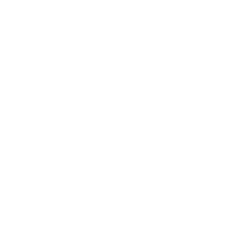

In [ ]:
fig, ax = plt.subplots()
anim = splt.animator(spike_rand, fig, ax)

HTML(anim.to_html5_video())

In [ ]:
# Save output: .gif, .mp4 etc.
# anim.save("random_spikes.gif")

### 3.2 Raster

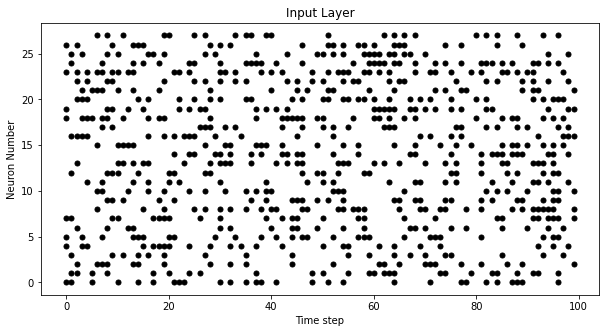

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_rand[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

# 마치며

스파이크 전환 및 생성은 여기까지입니다.
이 접근 방식은 이미지를 넘어 1차원 및 다차원 텐서로 일반화 할 수 있습니다.
`spikegen`의 참조 문서는 [여기](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html)에서 `spikeplot`의 참조 문서는 [여기](https://snntorch.readthedocs.io/en/latest/snntorch.spikeplot.html)에서 확인 할 수 있습니다.

[다음 튜토리얼]에서는 스파이킹 뉴런의 기본과 그것들을 사용하는 방법을 배울 것입니다.

이 프로젝트가 마음에 든다면 [Github repo](https://github.com/Neuro-AI-Lab/SNN-Tutorial-with-snnTorch)에서 ⭐을 눌러주세요 :)

# Additional Resources

* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)